# Import

In [1]:
import torch
from sklearn.cluster import KMeans
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from spectral import *
import matplotlib as mpl

from speclearn.deep_learning.predict import predict_data
from speclearn.tools.data_tools import *
from speclearn.deep_learning.ml_tools import Config, divide_data
from speclearn.deep_learning.model_utils import make_model
from speclearn.io.data.aoi import get_aoi_list_with_full_path
from speclearn.tools.constants import *
from speclearn.plot.map import *

sns.set_context('paper')

no_colors = 20
cmap = mpl.cm.get_cmap('viridis', no_colors)
colors = [mpl.colors.rgb2hex(cmap(c)[:3]) for c in range(0, no_colors)]

/tmp/ipykernel_1963654/3209928974.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis', no_colors)


# Data

In [2]:
aoi_list = get_aoi_list_with_full_path('/media/freya/rebin/M3/pickles_v2/nlong7200_nlat3600/train')
X_train, X_valid, X_test = divide_data(aoi_list, 500)

No. training files: 300
No. validation files: 100
No. test files: 100


# Neural network

In [3]:
no_latent = 6
config = {
    "model": "CVAE",
    "learning_rate": 0.00001,
    "epochs": 100,
    "no_batches": 256,
    "no_latent": 6,
    "type": 'Adam',
    "loss_function": 'MSE',
    "input_size": 71,
    "beta": 1,
    "patience": 5,
    "architecture": 2,
    "activation": 'sigmoid',
    "dropout": 0.5,
    "architecture": 4
}
run_name='ww4o202x'

model, criterion, optimizer = make_model(Config(config))

prev_model = wandb.restore(
    f'{run_name}_model.h5', f'freja-thoresen/M3-autoencoders/{run_name}', replace=True) 

model.load_state_dict(torch.load(prev_model.name,map_location=torch.device('cpu')))

<All keys matched successfully>

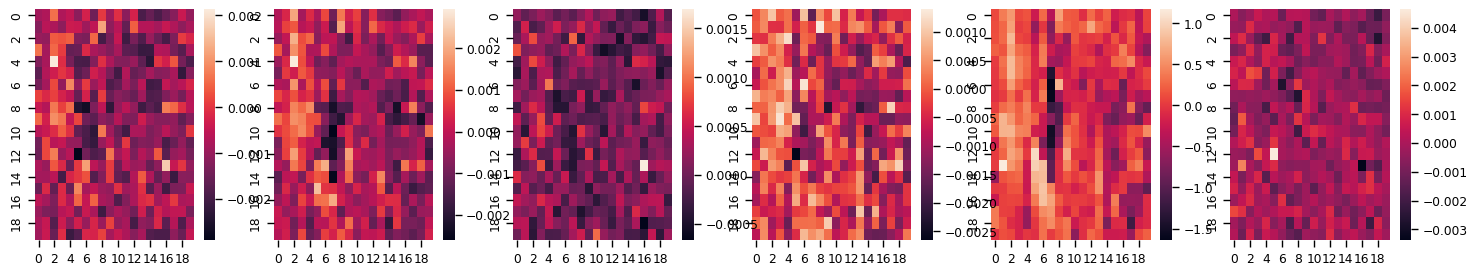

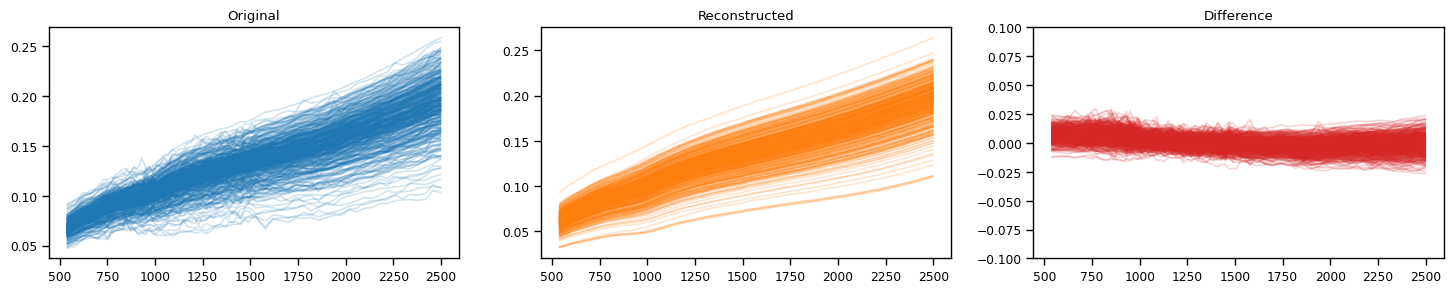

Text(0.5, 1.0, 'Clustered')

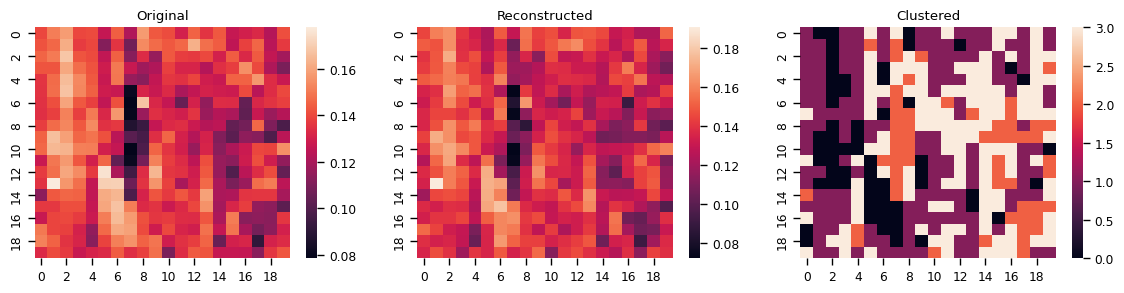

In [12]:
#recon, latent, data, coord, ml_data
recon, latent, data, coord, ml_data = predict_data(filename=X_test[3], no_latent=no_latent, model=model, crs=False, norm=False, process=False)

latent_2d = np.full_like(np.zeros((20,20,no_latent)), float('NaN'))
recon_2d = np.full_like(np.zeros((20,20, 71)), float('NaN'))

for i, (x, y) in enumerate(coord):
    recon_2d[x,y, :] = recon[i]
    latent_2d[x,y,:] = latent[i,:]

# Latent variables
fig, axs = plt.subplots(nrows=1, ncols=no_latent, figsize=(18,3))
for l in range(0, len(latent_2d[0,0,0:no_latent])):
    sns.heatmap(latent_2d[...,l], ax=axs[l])
#fig.suptitle(X_test[0], fontsize=16)

# Spectral reconstruction
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,3))

for i in range(0, 20):#data.shape[0]):
    for j in range(0, 20):#data.shape[1]):
        #if np.any(np.fabs(data[i,j,:]-recon_2d[i,j,:])>0.3):
            #continue
        axs[0].errorbar(GLOBAL_WAVELENGTH[:-12],data[i,j,:], alpha=0.2,c='C0')
        axs[1].errorbar(GLOBAL_WAVELENGTH[:-12],recon_2d[i,j,:], alpha=0.2,c='C1')
        axs[2].errorbar(GLOBAL_WAVELENGTH[:-12],data[i,j,:]-recon_2d[i,j,:], alpha=0.2,c='C3')
axs[2].set_ylim([-0.1,0.1])
axs[0].set_title('Original')
axs[1].set_title('Reconstructed')
axs[2].set_title('Difference')
plt.show()

# Heatmaps and clustering
kmeans = KMeans(n_clusters=4, random_state=0)
cluster, cluster_2d, kmeans = fit_kmeans(kmeans, data, latent, coord)

fig, axs = plt.subplots(ncols=3, figsize=(14,3))
sns.heatmap(recon_2d[:,:,45], ax=axs[1])#, vmin=0.0, vmax=1.0)
sns.heatmap(data[:,:,45], ax=axs[0])#, vmin=0.0, vmax=1.0)
sns.heatmap(cluster_2d, ax=axs[2])
axs[0].set_title('Original')
axs[1].set_title('Reconstructed')
axs[2].set_title('Clustered')

Reconstruction error [0.00431888 0.0044541  0.00440389 0.00440111 0.00464962 0.00465243
 0.00470719 0.00456947 0.00466571 0.00479984 0.00465206 0.0046146
 0.0047378  0.00464953 0.00474238 0.00477189 0.00461874 0.00458914
 0.00471055 0.00468636 0.00465005 0.00467812 0.00462616 0.00473683
 0.00465696 0.00479917 0.00483574 0.00476384 0.00477693 0.00482887
 0.00470677 0.00466671 0.00473942 0.00466897 0.00470384 0.00467055
 0.00472596 0.00478663 0.00482657 0.0048262  0.00486465 0.00496906
 0.00502772 0.00508421 0.00506548 0.00503825 0.00502726 0.00510607
 0.00522031 0.00524166 0.00525427 0.0052959  0.00542578 0.0055142
 0.00559039 0.00557513 0.00562273 0.00570928 0.00587307 0.00586047
 0.00595586 0.00605596 0.00605497 0.00619343 0.00624344 0.00626833
 0.00644784 0.00635751 0.00661379 0.00659372 0.00673199]
Mean reconstruction error 0.005112004840080198


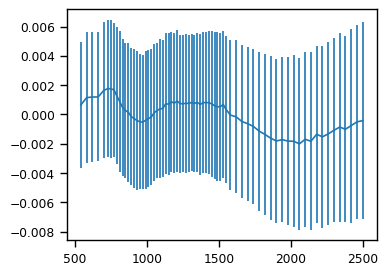

In [14]:
diff = []
for test_data in X_test:
    recon, latent, data, coord, ml_data = predict_data(filename=X_test[0], no_latent=no_latent, model=model, crs=False, norm=False, process=False)
    diff.append((recon-ml_data))
diff = np.array(diff)
diff = np.concatenate(diff, axis=0)

plt.figure(figsize=(4,3))
plt.errorbar(GLOBAL_WAVELENGTH[:-12], np.nanmean(diff, axis=0), np.nanstd(diff, axis=0))
print('Reconstruction error', np.nanstd(diff, axis=0))
print('Mean reconstruction error', np.nanmean(np.nanstd(diff, axis=0)))